In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import copy

from plotting import plot_utils, summary_plots, load_fits
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, prf_utils, numpy_utils

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False, return_filename=False) \
       for ss in subjects]

In [55]:
# pull out the pRF params

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = np.round(sigma * screen_eccen_deg, 2)
angle_fwrf = np.round(angle_fwrf,2)
eccen_fwrf = np.round(eccen_fwrf,2)

x_fwrf, y_fwrf = x*screen_eccen_deg, y*screen_eccen_deg

In [56]:
# loading pRF parameters from independent mapping task data

from utils import nsd_utils, prf_utils

angle_mapping = []
eccen_mapping = []
size_mapping = []
rsq_mapping = []

for si,ss in enumerate(subjects):
    
    voxel_mask = roi_def.ss_roi_defs[si].voxel_mask
    a,e,s, exp,gain,rsq = nsd_utils.load_prf_mapping_pars(subject=ss, \
                                                      voxel_mask = voxel_mask)
    angle_mapping.append(a)
    eccen_mapping.append(e)
    size_mapping.append(s)
    rsq_mapping.append(rsq)
    
# these are in degrees
angle_mapping = np.concatenate(angle_mapping)
eccen_mapping = np.concatenate(eccen_mapping)
size_mapping = np.concatenate(size_mapping)
rsq_mapping = np.concatenate(rsq_mapping)

x_mapping, y_mapping = prf_utils.pol_to_cart(angle_mapping, eccen_mapping)

In [7]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_types = ['texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs', \
                'texture_pyramid_ridge_4ori_4sf_pcaHL', \
                'texture_pyramid_ridge_4ori_4sf_pcaHL_use_mappingtask_pRFs']
short_names = ['texture pRFs', 'alexnet pRFs', 'mapping task pRFs']
out = [[load_fits.load_fit_results(subject=ss, fitting_type=ft, \
                                  n_from_end=0, verbose=False) \
                                   for ss in subjects] for ft in fitting_types]


#### Make ROI definitions

In [58]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [59]:
# don't count angle for RFs that are at the fovea
no_angle = (eccen_fwrf<10e-2) | (eccen_mapping<10e-2)
np.sum(no_angle)

26631

In [72]:
r2_cutoff = 0.01;

nc_cutoff = 0.01
alexnet_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
nc = np.concatenate([nsd_utils.get_nc(ss) for ss in subjects], axis=0)
abv_thresh = (alexnet_r2>r2_cutoff) & (nc>nc_cutoff)

n_pars = 3;
par_names = ['polar angle','eccen','size']
corrs_each_par = np.zeros((n_rois, n_pars),dtype=float)

for rr in range(n_rois):
                          
    vinds = roi_def.get_indices(rr) & \
            abv_thresh & \
            ~no_angle

    xvals = angle_mapping[vinds]
    yvals = angle_fwrf[vinds]
    rho = circ_utils.circ_corr_coef(xvals/180*np.pi, yvals/180*np.pi)
    
    corrs_each_par[rr,0] = rho
    
    vinds = roi_def.get_indices(rr) & \
            abv_thresh
    
    xvals = eccen_mapping[vinds]
    yvals = eccen_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    corrs_each_par[rr,1] = rho
    
    xvals = size_mapping[vinds]
    yvals = size_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    corrs_each_par[rr,2] = rho
    
df = pd.DataFrame(corrs_each_par, index=roi_names, columns=par_names)
fn2save = os.path.join(default_paths.fig_path, 'prf_comparison_0.01.csv')
df.to_csv(fn2save)
df

,polar angle,eccen,size
V1,0.428126,0.448677,0.009641
V2,0.474062,0.542477,0.016030
V3,0.506908,0.096125,0.012008
hV4,0.534369,0.039559,0.330581
V3ab,0.377088,0.035837,0.002556
IPS,0.078896,0.026390,-0.003447
OPA,0.133033,0.008052,0.018080
PPA,0.017241,-0.005262,0.011541
RSC,-0.001164,0.021542,0.007064
OFA,0.203377,0.246193,0.182663


In [73]:
r2_cutoff = 0.10;

nc_cutoff = 0.01
alexnet_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
nc = np.concatenate([nsd_utils.get_nc(ss) for ss in subjects], axis=0)
abv_thresh = (alexnet_r2>r2_cutoff) & (nc>nc_cutoff)

n_pars = 3;
par_names = ['polar angle','eccen','size']
corrs_each_par = np.zeros((n_rois, n_pars),dtype=float)

for rr in range(n_rois):
                          
    vinds = roi_def.get_indices(rr) & \
            abv_thresh & \
            ~no_angle

    xvals = angle_mapping[vinds]
    yvals = angle_fwrf[vinds]
    rho = circ_utils.circ_corr_coef(xvals/180*np.pi, yvals/180*np.pi)
    
    corrs_each_par[rr,0] = rho
    
    vinds = roi_def.get_indices(rr) & \
            abv_thresh
    
    xvals = eccen_mapping[vinds]
    yvals = eccen_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    corrs_each_par[rr,1] = rho
    
    xvals = size_mapping[vinds]
    yvals = size_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    corrs_each_par[rr,2] = rho
    

df = pd.DataFrame(corrs_each_par, index=roi_names, columns=par_names)
fn2save = os.path.join(default_paths.fig_path, 'prf_comparison_0.10.csv')
df.to_csv(fn2save)
df

,polar angle,eccen,size
V1,0.778483,0.677076,0.021988
V2,0.769696,0.693188,0.178766
V3,0.777525,0.069782,0.318312
hV4,0.713464,0.462209,0.389586
V3ab,0.709434,0.278072,0.049760
IPS,0.150560,0.071060,-0.021447
OPA,0.221443,0.024214,0.036582
PPA,0.020780,0.008105,0.031748
RSC,-0.000522,-0.012364,-0.017258
OFA,0.400207,0.295353,0.177269


Text(0.5, 0.98, 'pRF polar angle estimates, comparing models')

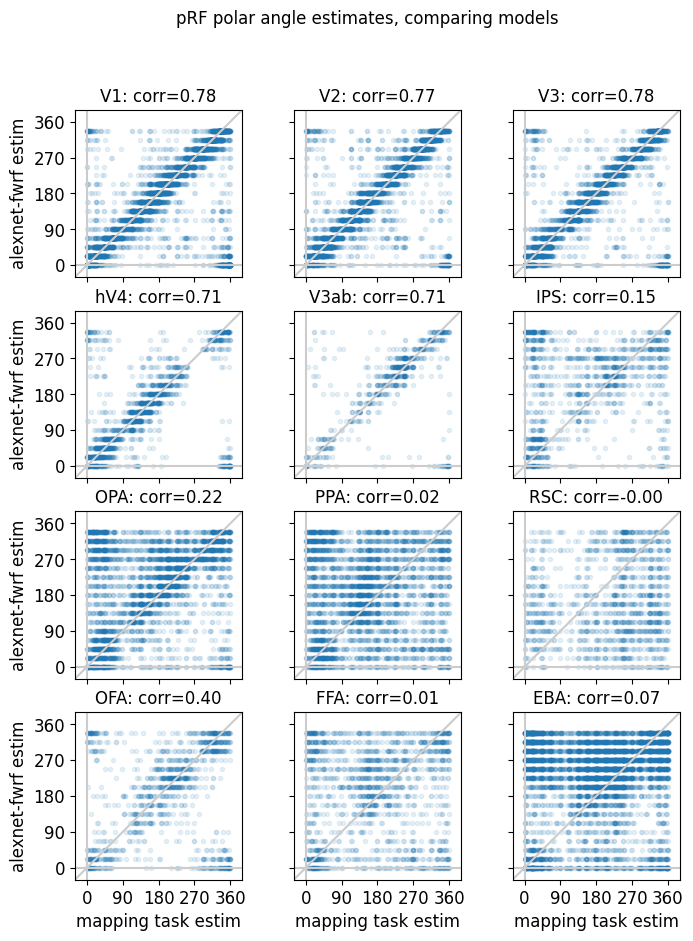

In [61]:
from utils import circ_utils

# rr2plot = [0,1,2,3]
# rr2plot = [0, 3, 5, 8]
rr2plot = np.arange(n_rois)

lims = [-30,390]

plt.figure(figsize=(8,10))

for ri, rr in enumerate(rr2plot):
    plt.subplot(4,3,ri+1)

    vinds = roi_def.get_indices(rr) & \
            abv_thresh & \
            ~no_angle

    xvals = angle_mapping[vinds]
    yvals = angle_fwrf[vinds]
    rho = circ_utils.circ_corr_coef(xvals/180*np.pi, yvals/180*np.pi)
    
    plt.plot(xvals, yvals, '.',alpha=0.10)
    plt.axis('square')
    plt.title('%s: corr=%.2f'%(roi_names[rr], rho))
    plt.xlim(lims)
    plt.ylim(lims)
    
    
    plt.plot(lims, lims, color=[0.8, 0.8, 0.8])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    if ri>8:
        plt.xlabel('mapping task estim')
        plt.xticks(np.arange(0,361,90)) 
    else:
        plt.xticks(np.arange(0,361,90),[]) 
    if np.mod(ri,3)==0:
        plt.ylabel('alexnet-fwrf estim')
        plt.yticks(np.arange(0,361,90))
    else:
        plt.yticks(np.arange(0,361,90),[])

plt.suptitle('pRF polar angle estimates, comparing models')

    # fn2save = os.path.join(default_paths.fig_path, 'prfs_compare_mappingtask.pdf')
    # plt.savefig(fn2save)

Text(0.5, 0.98, 'pRF size estimates, comparing models')

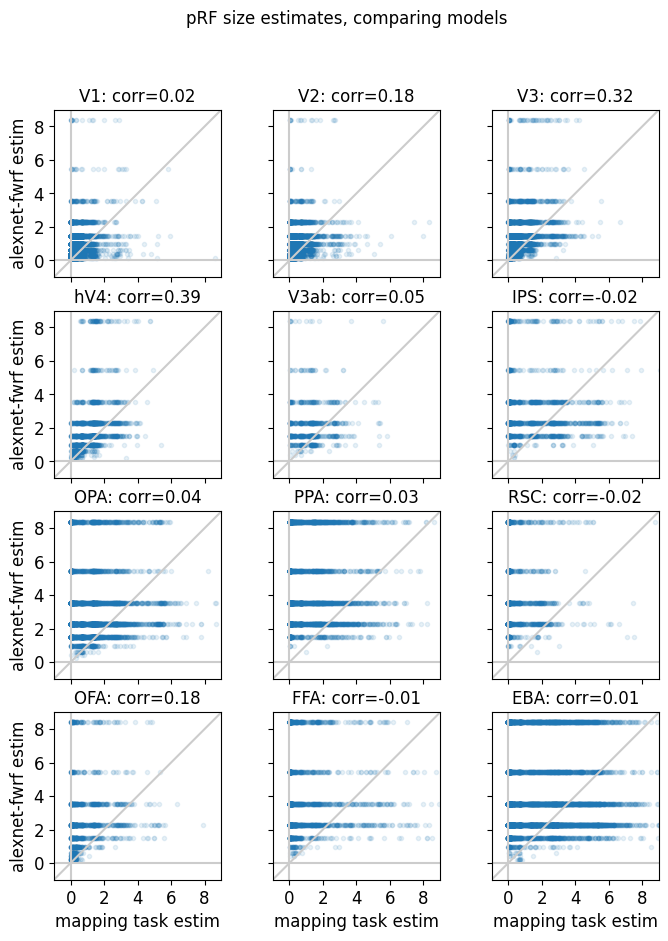

In [62]:

rr2plot = np.arange(n_rois)

lims = [-1,9]

plt.figure(figsize=(8,10))

for ri, rr in enumerate(rr2plot):
    
    plt.subplot(4,3,ri+1)

    vinds = roi_def.get_indices(rr) & \
            abv_thresh 

    xvals = size_mapping[vinds]
    yvals = size_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    plt.plot(xvals, yvals, '.',alpha=0.10)
    plt.axis('square')
    plt.title('%s: corr=%.2f'%(roi_names[rr], rho))
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.plot(lims, lims, color=[0.8, 0.8, 0.8])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    if ri>8:
        plt.xlabel('mapping task estim')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
    if np.mod(ri,3)==0:
        plt.ylabel('alexnet-fwrf estim')
        plt.yticks([0,2,4,6,8])
    else:
        plt.yticks([0,2,4,6,8],[])

plt.suptitle('pRF size estimates, comparing models')

    # fn2save = os.path.join(default_paths.fig_path, 'prfs_compare_mappingtask.pdf')
    # plt.savefig(fn2save)

Text(0.5, 0.98, 'pRF eccen estimates, comparing models')

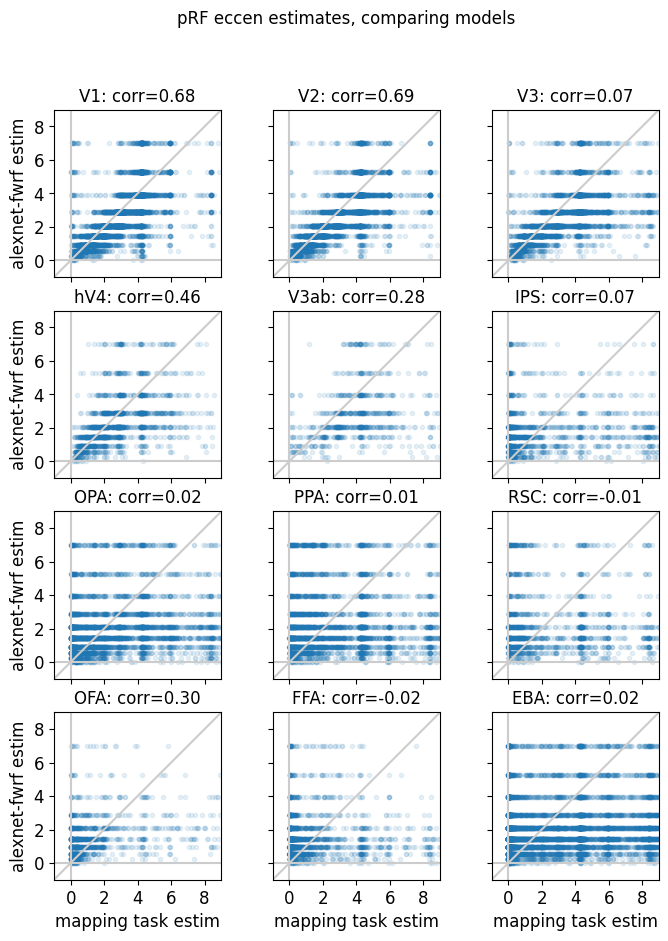

In [67]:

rr2plot = np.arange(n_rois)

lims = [-1,9]

plt.figure(figsize=(8,10))

for ri, rr in enumerate(rr2plot):
    
    plt.subplot(4,3,ri+1)

    vinds = roi_def.get_indices(rr) & \
            abv_thresh 

    xvals = eccen_mapping[vinds]
    yvals = eccen_fwrf[vinds]
    rho = np.corrcoef(xvals, yvals)[0,1]
    
    plt.plot(xvals, yvals, '.',alpha=0.10)
    plt.axis('square')
    plt.title('%s: corr=%.2f'%(roi_names[rr], rho))
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.plot(lims, lims, color=[0.8, 0.8, 0.8])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    if ri>8:
        plt.xlabel('mapping task estim')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
    if np.mod(ri,3)==0:
        plt.ylabel('alexnet-fwrf estim')
        plt.yticks([0,2,4,6,8])
    else:
        plt.yticks([0,2,4,6,8],[])

plt.suptitle('pRF eccen estimates, comparing models')

    # fn2save = os.path.join(default_paths.fig_path, 'prfs_compare_mappingtask.pdf')
    # plt.savefig(fn2save)